In [1]:
import os
import json

In [2]:
base_dir = "/root/workspace/PlantVillage_Corn"
folders = ['Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 
         'Corn_(maize)___Common_rust_',
         'Corn_(maize)___healthy',
         'Corn_(maize)___Northern_Leaf_Blight']

labels = ['一张玉米灰斑病的玉米叶片图像',
         '一张玉米锈病的玉米叶片图像',
         '一张健康的玉米叶片图像',
         '一张玉米叶斑病的玉米叶片图像']

# 对应的文本说明，用来描述纹理特点，辅助LLM进行标注
# 让LLM能把图片和文本里的内容对应起来
# prompt： 以下为一些病害症状：{discription[i]}请结合这些症状描述，生成一段对于图片的描述，不要有多余输出。
description = ['1.叶片上有褐色斑点。2.浅褐色条纹或不规则的灰色到褐色长条斑，病斑中间灰色。3.叶片有黑色霉层，即病菌的分生孢子梗和分生孢子。',
              '1.叶片有淡黄白色小斑，四周有黄色晕圈。2.突起的黄褐色乃至红褐色疱斑。3.有圆形或长圆形的夏孢子堆。孢子堆表皮破裂后散出铁锈状夏孢子。4.有黑色疱斑，即病菌的冬孢子堆，长椭圆形，疱斑破裂散出黑褐色粉状物。',
              '空',
              '1.叶片上出现雪茄形或椭圆形的坏死灰绿色病斑,通常具有烟灰般的外观。2.随着病害的发展，病斑会融合在一起，形成大面积的死叶组织。']

In [3]:

# 初始化一个空列表，用于存储所有图片信息
images_data = []

# 遍历ABC三个文件夹
for folder in folders:
    folder_path = os.path.join(base_dir, folder)
    
    # 确保文件夹存在
    if os.path.exists(folder_path):
        # 遍历文件夹中的所有文件
        for filename in os.listdir(folder_path):
            # 仅处理图片文件（可以根据需要筛选文件类型）
            if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                # 获取图片的完整路径
                file_path = os.path.join(folder_path, filename)
                
                id = folders.index(folder)
                
                # 添加图片信息到列表中
                images_data.append({
                    'path': file_path,
                    'id': id,
                    'label': labels[id] + '\n' + description[id]
                })

# 将图片信息保存到JSON文件
print(f"count images:{len(images_data)}") # 1323 images in total (不是很多)
with open('images_data.json', 'w') as json_file:
    # dump to json chinese
    json.dump(images_data, json_file, indent=4, ensure_ascii=False)

print("图片信息已成功保存到images_data.json")

count images:1323
图片信息已成功保存到images_data.json


In [4]:
import base64
import requests

def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')

In [5]:
from call_gpt import call_gpt
def get_gpt_description(image_path,idx):
    base64_image = encode_image(image_path)
    messages = [
        {
            "role": "user",
            "content": [
                {
                "type": "text",
                "text": f"以下为一些玉米病害症状：{description[idx]}请结合这些症状描述，生成一段对于图片的描述，不要有多余输出。"
                },
                {
                "type": "image_url",
                "image_url": {
                    "url": f"data:image/jpeg;base64,{base64_image}"
                }
                }
            ]
        }
    ]
    return call_gpt(messages)

In [8]:
# 处理数据集
# read json
import tqdm

with open('images_data.json', 'r') as json_file:
    images_data = json.load(json_file)


output_list = []

# tqdm images_data
for i,row in tqdm.tqdm(enumerate(images_data)): # row : a dict with path, id
    idx = row['id']
    img_path = row['path']
    if idx==2:# read an healthy image!
        final_description = labels[idx]+'。' # 一张健康的玉米叶片图像 
    else:
        ans = get_gpt_description(image_path=img_path, idx=idx)
        final_description = labels[idx]+'。'+ans
    output_list.append({
        'path': img_path,
        'id': idx,
        'label': final_description
    })
    # for test
    # if i>4:
    #     break

with open('images_with_descriptions.json', 'w') as json_file:
    # dump to json chinese
    json.dump(output_list, json_file, indent=4, ensure_ascii=False)

5it [00:11,  2.28s/it]


In [9]:
from PIL import Image
from IPython.display import display

def example(idx,img_path):
    # 生成几个样例来吧
    ans = get_gpt_description(image_path = img_path
                            ,idx=idx)
    final_description = labels[idx]+'。'+ans
    print(final_description)
    # show image
    image = Image.open(img_path)
    display(image)


一张玉米锈病的玉米叶片图像。图片中的玉米叶片上有突起的黄褐色乃至红褐色疱斑，疱斑表皮破裂后散出铁锈状夏孢子。


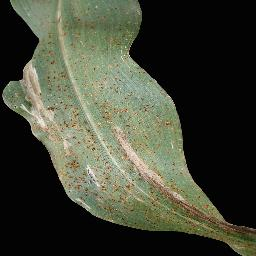

In [10]:
img_path = '/root/workspace/PlantVillage_Corn/Corn_(maize)___Common_rust_/RS_Rust 1564.JPG'
idx = 1
example(idx,img_path)

一张玉米灰斑病的玉米叶片图像。叶片上有浅褐色条纹或不规则的灰色到褐色长条斑，病斑中间灰色。


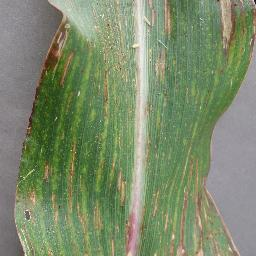

In [11]:
img_path = "/root/workspace/PlantVillage_Corn/Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot/0ce6543f-9694-4b3a-b767-9bc909f54f73___RS_GLSp 4663 copy.jpg"
idx = 0
example(idx,img_path)

一张玉米叶斑病的玉米叶片图像。图片中的玉米叶片上出现了椭圆形的坏死灰绿色病斑，具有烟灰般的外观。


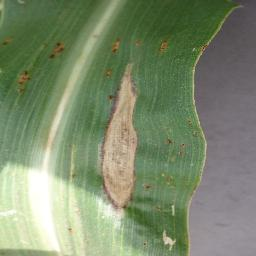

In [12]:
img_path = "/root/workspace/PlantVillage_Corn/Corn_(maize)___Northern_Leaf_Blight/00a55069-3fa3-405b-8d87-4d3408a6ed98___RS_NLB 3645.JPG"
idx = 3
example(idx,img_path)

In [ ]:
# 尝试调用一下GPT吧
# read in json file
with open('images_data.json', 'r') as json_file:
    images_data = json.load(json_file)

for idx,row in enumerate(images_data):
    